In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Veri yolu
train_dir = "D:/archive/training"
test_dir = "D:/archive/testing"
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [3]:
# Görselleri yükle ve boyutlandır
def load_images(data_dir, classes, img_size=(128,128)):
    images, labels = [], []
    for cls in classes:
        cls_folder = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            images.append(img / 255.0)
            labels.append(cls)
    return np.array(images), np.array(labels)

X, y = load_images(train_dir, classes)

In [4]:
# Etiketleri sayısal ve one-hot yap
le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(y), num_classes=len(classes))

# Eğitim ve doğrulama
X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [5]:
# Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Softmax ve categorical_crossentropy
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\hysen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [7]:
# Modeli eğit
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - accuracy: 0.5988 - loss: 0.9210 - val_accuracy: 0.6868 - val_loss: 0.8742
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.7446 - loss: 0.6543 - val_accuracy: 0.7743 - val_loss: 0.5589
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.7888 - loss: 0.5461 - val_accuracy: 0.7699 - val_loss: 0.5480
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 238ms/step - accuracy: 0.8081 - loss: 0.4960 - val_accuracy: 0.7874 - val_loss: 0.5367
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.8175 - loss: 0.4783 - val_accuracy: 0.8189 - val_loss: 0.4360
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 238ms/step - accuracy: 0.8328 - loss: 0.4301 - val_accuracy: 0.8486 - val_loss: 0.4094
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.8468 - loss: 0.4090 - val_accuracy: 0.8084 - val_loss: 0.5501
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 227ms/step - accuracy: 0.8442 - loss: 0

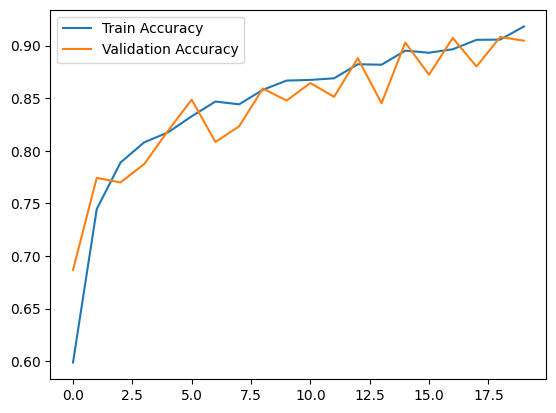

In [8]:
# Eğitim grafikleri
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [23]:

# Test için rastgele görseller seçme
def sample_test_images(test_dir, classes, num_per_class=10, img_size=(128,128)):
    sample_images, true_labels = [], []
    for cls in classes:
        cls_folder = os.path.join(test_dir, cls)
        img_files = random.sample(os.listdir(cls_folder), num_per_class)
        for img_file in img_files:
            img_path = os.path.join(cls_folder, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            sample_images.append(img / 255.0)
            true_labels.append(cls)
    return np.array(sample_images), true_labels

X_test, true_labels = sample_test_images(test_dir, classes, num_per_class=10)


In [24]:
# Tahmin
pred_probs = model.predict(X_test)
predicted_classes = [classes[np.argmax(p)] for p in pred_probs]

# Test doğruluğu
accuracy = np.mean([predicted_classes[i]==true_labels[i] for i in range(len(true_labels))])
print(f"Test doğruluk: {accuracy*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test doğruluk: 92.50%


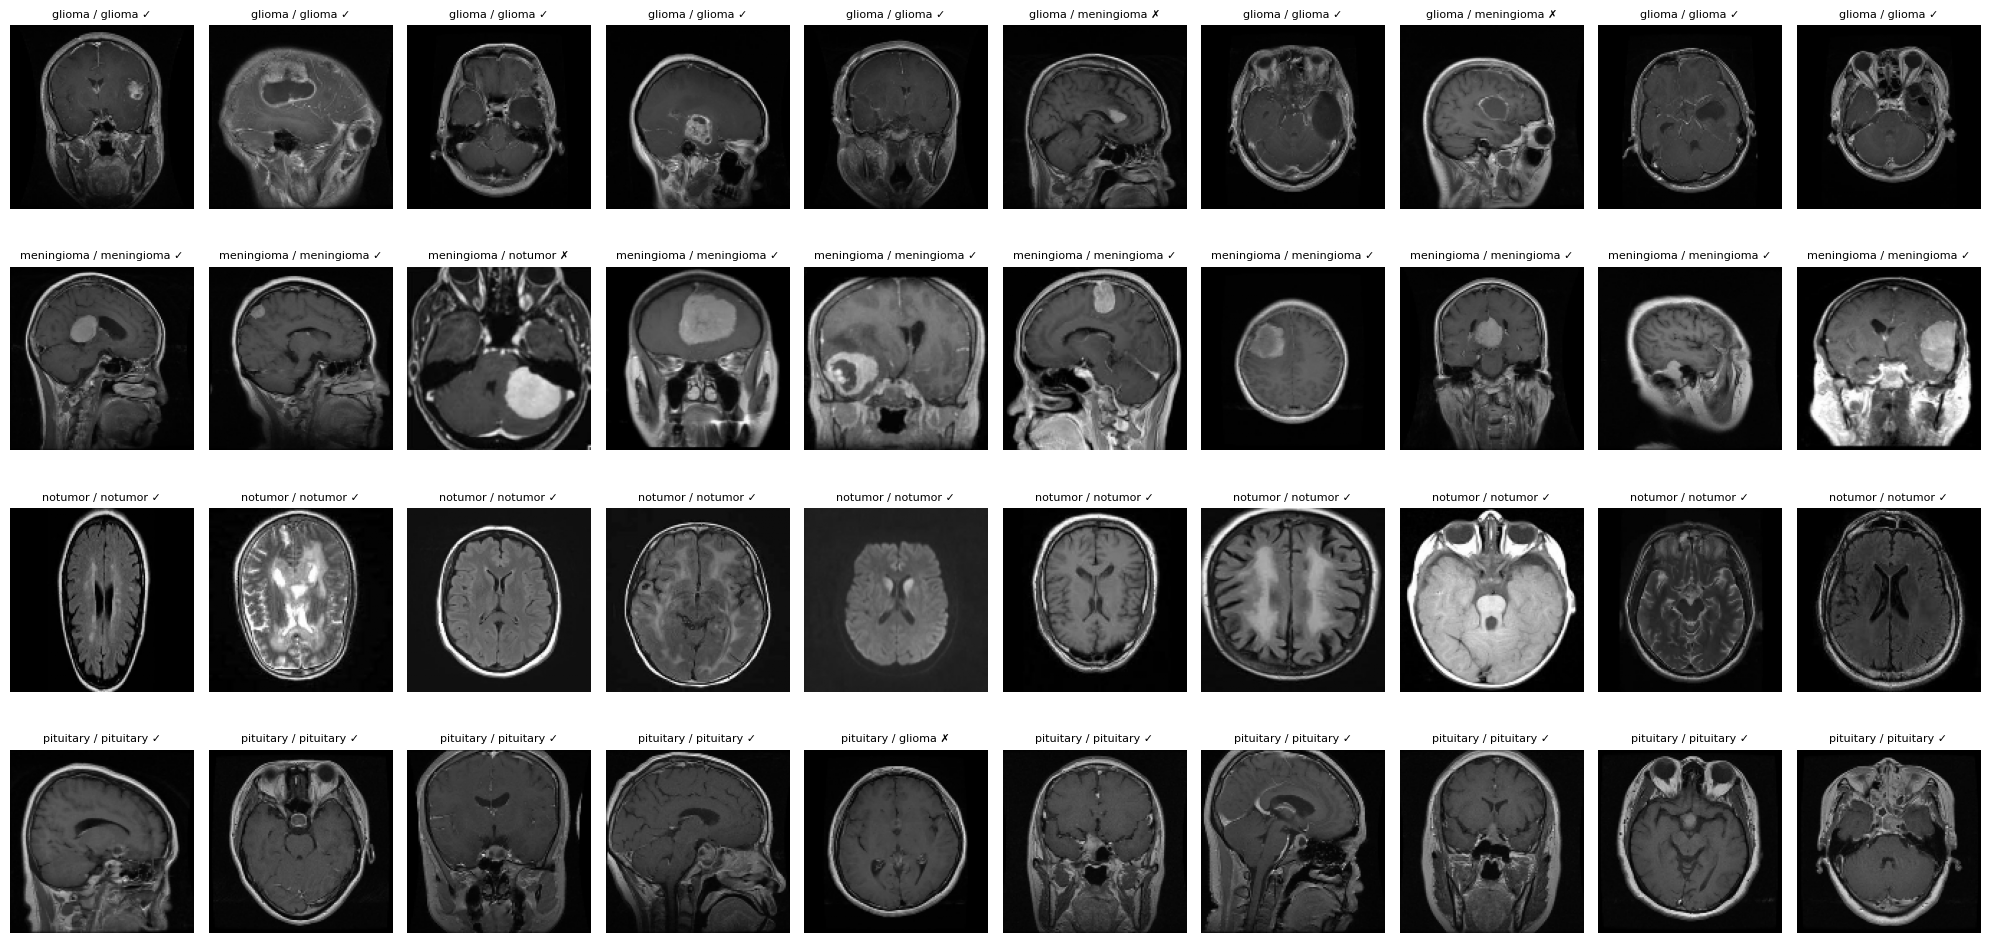

In [12]:
# Sonuçları görselle göster
num_total = len(X_test)
cols = 10
rows = (num_total // cols) + (num_total % cols > 0)
plt.figure(figsize=(20, rows*2.5))
for i in range(num_total):
    plt.subplot(rows, cols, i+1)
    plt.imshow(X_test[i])
    result = "✓" if predicted_classes[i]==true_labels[i] else "✗"
    plt.title(f"{true_labels[i]} / {predicted_classes[i]} {result}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()